# LANL Splitting

This notebook splits the LANL database into a nomination cohort and a validation cohort.
The validation cohort is balanced to match the global HIV prevelence.

In [1]:
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(18)30647-9/fulltext?rss=yes#relatedClinic

This systematic review and global survey yielded 2203 datasets with 383 519 samples from 116 countries in 1990–2015. Globally, subtype C accounted for 46.6% (16 280 897/34 921 639 of PLHIV) of all HIV-1 infections in 2010–15. Subtype B was responsible for 12.1% (4 235 299/34 921 639) of infections, followed by subtype A (10.3%; 3 587 003/34 921 639), CRF02_AG (7.7%; 2 705 110/34 921 639), CRF01_AE (5.3%; 1 840 982/34 921 639), subtype G (4.6%; 1 591 276/34 921 639), and subtype D (2.7%; 926 255/34 921 639). Subtypes F, H, J, and K combined accounted for 0.9% (311 332/34 921 639) of infections.

In [2]:
# From above
target_dist = {'B': 0.121, 'A': 0.103, 'C': 0.466, '02_AG': 0.077,  '01_AE': 0.053, 'G': 0.046, 'D': 0.027}
target_dist['other'] = 1-sum(target_dist.values())
target_dist

{'B': 0.121,
 'A': 0.103,
 'C': 0.466,
 '02_AG': 0.077,
 '01_AE': 0.053,
 'G': 0.046,
 'D': 0.027,
 'other': 0.10699999999999998}

In [3]:
SOURCE_DATA = '../data/LANL.reference.fasta'

In [4]:
def get_subtype(st):
    """ Extract suptype information from:
    A.CH.03.HIV_CH_BID_V3538_2003.JQ403028
    """
    
    subtype = st.split('.')[0]
    
    if subtype[0].isalpha():
        # Handle A1, B2, A3, etc sub-subtypes
        subtype = subtype[0]
        
    if subtype not in target_dist:
        subtype = 'other'
    return subtype

In [5]:
seqs = []

with open(SOURCE_DATA) as handle:
    for seqR in SeqIO.parse(handle, 'fasta'):
        seqs.append({'id': seqR.id, 'seq': str(seqR.seq),
                     'subtype': get_subtype(seqR.id)})

seqs = pd.DataFrame(seqs)
seqs.head()

,id,seq,subtype
0,B.FR.83.HXB2_LAI_IIIB_BRU.K03455,TGGAAGGGCTAATTCACTCCCAACGAAGACAAGATATCCTTGATCT...,B
1,A.CD.87.P4039.MH705157,GGATGGGTTAATTTACTCCCGGAAAAGACAAGAGATCCTTGATCTG...,A
2,A.CH.03.HIV_CH_BID_V3538_2003.JQ403028,ATGGGTGCGAGAGCGTCAATATTAAGCGGGGGAAAATTAGATGCAT...,A
3,A.ZA.04.04ZASK162B1.DQ396400,TCTGTTGTGTGGCTCTGGTAACTAGAGATCCCTCAGACCACTCTAG...,A
4,A1.AU.03.PS1044_Day0.DQ676872,ATGGGTGCGAGAGCGTCAATATTAAGCGGGGGAAGATTAGATGCAT...,A


In [6]:
def subtype_sampling(target_values, seq_df, target_n, random_state):
    
    test = []
    
    for subtype, freq in target_values.items():
        mask = seq_df['subtype']==subtype
        print(subtype, int(target_n*freq), mask.sum())
        test.append(seq_df.loc[mask].sample(random_state = random_state,
                                            n = int(target_n*freq)))
        
    test_df = pd.concat(test,axis=0)
    nomination_df = seq_df.drop(test_df.index)
    
    return test_df, nomination_df
    
def frame2fasta(df, path):
    
    with open(path, 'w') as handle:
        for _, row in df.iterrows():
            handle.write(f'>{row["id"]}\n{row["seq"]}\n')
    
    

In [7]:
target = 1500

for state in range(5):
    print('random_state', state)
    tdf, ndf = subtype_sampling(target_dist, seqs, target, state)
    print()
    frame2fasta(ndf, f'../data/nominate.{state}.fasta')
    frame2fasta(tdf, f'../data/test.{state}.fasta')

random_state 0
B 181 1615
A 154 532
C 699 827
02_AG 115 148
01_AE 79 420
G 69 92
D 40 82
other 160 1009

random_state 1
B 181 1615
A 154 532
C 699 827
02_AG 115 148
01_AE 79 420
G 69 92
D 40 82
other 160 1009

random_state 2
B 181 1615
A 154 532
C 699 827
02_AG 115 148
01_AE 79 420
G 69 92
D 40 82
other 160 1009

random_state 3
B 181 1615
A 154 532
C 699 827
02_AG 115 148
01_AE 79 420
G 69 92
D 40 82
other 160 1009

random_state 4
B 181 1615
A 154 532
C 699 827
02_AG 115 148
01_AE 79 420
G 69 92
D 40 82
other 160 1009



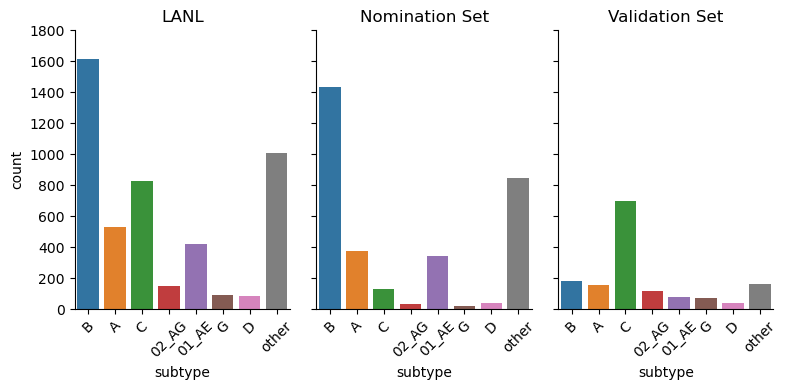

In [8]:
fig, (orig_ax, nom_ax, valid_ax) = plt.subplots(1, 3, figsize=(8,4), sharex=True, sharey=True)


orig_ax = sns.countplot(data = seqs,
                   x = 'subtype',
                   order = target_dist.keys(),
                   ax = orig_ax)
orig_ax.set_title('LANL')

sns.countplot(data = ndf,
                   x = 'subtype',
                   order = target_dist.keys(),
                   ax=nom_ax)
nom_ax.set_title('Nomination Set')
nom_ax.set_ylabel('')


sns.countplot(data = tdf,
                   x = 'subtype',
                   order = target_dist.keys(),
                   ax=valid_ax)
valid_ax.set_title('Validation Set')
valid_ax.set_ylabel('')

for ax in (orig_ax, nom_ax, valid_ax):
    
    ax.set_xticklabels(target_dist.keys(), rotation=45)
    ax.set_ylim(0, 1800)
    sns.despine(ax=ax)
    
fig.tight_layout()
fig.savefig('../results/dataset_figures/splitting.high.png', dpi=300)
fig.savefig('../results/dataset_figures/splitting.low.png', dpi=300)

In [9]:
with open('../results/datasplit.yaml', 'w') as handle:
    handle.write(f'nominate_seqs: {len(ndf.index)}\n')
    handle.write(f'test_seqs: {len(tdf.index)}\n')